# Initialization

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas, numpy, string, textblob
import pickle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost
from keras import layers, models, optimizers
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt

In [4]:
#Load training data
df_train = pandas.read_csv('/content/drive/MyDrive/data/train.csv')
# df_train = df_train.truncate(after=10000)
#Load testing data
df_test = pandas.read_csv('/content/drive/MyDrive/data/test.csv')

In [5]:
df_train.head()
df_train.info()
df_count = df_train.groupby(['Class Index'], as_index = False).agg({'Title': 'count', 'Description': 'count'})
df_count.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


,Class Index,Title,Description
0,1,30000,30000
1,2,30000,30000
2,3,30000,30000
3,4,30000,30000


# Text Pre-processing

In [6]:
!pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00


In [7]:
import re, unidecode
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [8]:
# Needed only once
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result
def remove_slash_with_space(text):
    return text.replace('\\', " ")
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
def text_lowercase(text):
    return text.lower()
def remove_whitespace(text):
    return  " ".join(text.split())
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)
def stem_words(text):
    stemmer = PorterStemmer()
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stems)
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return ' '.join(lemmas)

In [10]:
# Perform preprocessing
def perform_preprocessing(text):
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = text_lowercase(text)
    text = remove_slash_with_space(text)
    text = remove_punctuation(text)
    text = stem_words(text)
    text = lemmatize_words(text)
    text = remove_whitespace(text)
    return text

df_train['Title'] = df_train['Title'].apply(perform_preprocessing)
df_train['Description'] = df_train['Description'].apply(perform_preprocessing)
df_test['Title'] = df_test['Title'].apply(perform_preprocessing)
df_test['Description'] = df_test['Description'].apply(perform_preprocessing)

<ipython-input-9-b05113031441>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [11]:
# Train test split
X_train = df_train['Description']
X_test = df_test['Description']
y_train = df_train['Class Index']
y_test = df_test['Class Index']

In [12]:
# Feature Engineering
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)
X_train_count =  count_vect.transform(X_train)
X_test_count =  count_vect.transform(X_test)

In [13]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

In [14]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [15]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X_train)
X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:558: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [16]:
# label encode the target variablea
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

encoder = preprocessing.LabelBinarizer()
encoder.fit(y_train)
y_train_bi = encoder.transform(y_train)
y_test_bi = encoder.transform(y_test)

# **MODEL SELECTION AND TRAINING**


This function trains a given classifier on the training data, predicts labels for the test data, and returns the accuracy score.

---


X : The feature matrix of the training data

y : The target labels of the training data.

In [17]:
def train_model(classifier, X_train, y_train, X_test, y_test, is_neural_net=False):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    return metrics.accuracy_score(predictions, y_test)

**Naive Bayes Classifier**

This code snippet trains Naive Bayes classifiers on different types of feature vectors (count vectors, word-level TF-IDF vectors, n-gram level TF-IDF vectors, and character-level TF-IDF vectors) and prints their accuracies.

NB, Count Vectors:  0.8923684210526316
NB, WordLevel TF-IDF:  0.8828947368421053
NB, N-Gram Vectors:  0.8790789473684211
NB, CharLevel Vectors:  0.845657894736842


<BarContainer object of 4 artists>

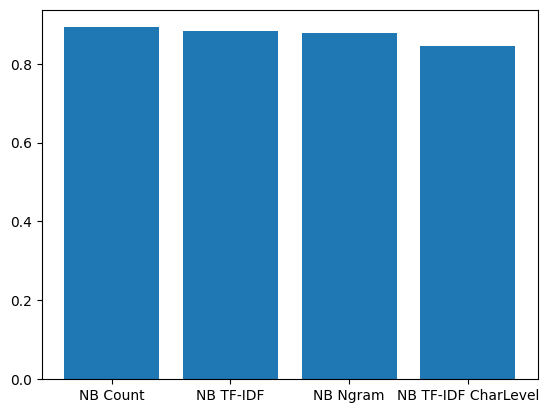

In [19]:
# Naive Bayes
# on Count Vectors
accuracy1 = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_test_count, y_test)
print("NB, Count Vectors: ", accuracy1)
'''  '''
# on Word Level TF IDF Vectors
accuracy2 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB, WordLevel TF-IDF: ", accuracy2)

# on Ngram Level TF IDF Vectors
accuracy3 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("NB, N-Gram Vectors: ", accuracy3)

# on Character Level TF IDF Vectors
accuracy4 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("NB, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['NB Count', 'NB TF-IDF','NB Ngram', 'NB TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  0.8085526315789474
LR, WordLevel TF-IDF:  0.8793421052631579
LR, N-Gram Vectors:  0.8801315789473684
LR, CharLevel Vectors:  0.8696052631578948


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<BarContainer object of 4 artists>

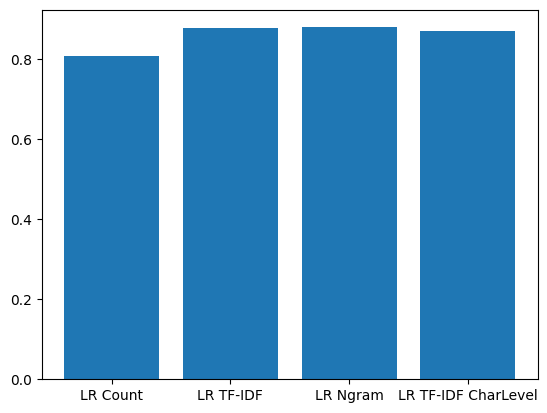

In [20]:
# # Logistic Regression on Count Vectors
# accuracy1 = train_model(linear_model.LogisticRegression(), X_train_count, y_train, X_test_count, y_test)
# print("LR, Count Vectors: ", accuracy1)

# # Logistic Regression on Word Level TF IDF Vectors
# accuracy2 = train_model(linear_model.LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
# print("LR, WordLevel TF-IDF: ", accuracy2)

# # Logistic Regression on Ngram Level TF IDF Vectors
# accuracy3 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
# print("LR, N-Gram Vectors: ", accuracy3)

# # Logistic Regression on Character Level TF IDF Vectors
# accuracy4 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
# print("LR, CharLevel Vectors: ", accuracy4)

# df = {'ModelType': ['LR Count', 'LR TF-IDF','LR Ngram', 'LR TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
# df = pandas.DataFrame(df) #
# plt.bar(df['ModelType'], df['Accuracy'])



# iteration limit error solving
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Function to train model
def train_model(model, X_train, y_train, X_test, y_test):
    scaler = StandardScaler(with_mean=False)  # Set with_mean=False for sparse input
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    accuracy = model.score(X_test_scaled, y_test)
    return accuracy

# Logistic Regression on Count Vectors
accuracy1 = train_model(LogisticRegression(max_iter=1000), X_train_count, y_train, X_test_count, y_test)
print("LR, Count Vectors: ", accuracy1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy2 = train_model(LogisticRegression(max_iter=1000), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR, WordLevel TF-IDF: ", accuracy2)

# Logistic Regression on Ngram Level TF IDF Vectors
accuracy3 = train_model(LogisticRegression(max_iter=1000), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("LR, N-Gram Vectors: ", accuracy3)

# Logistic Regression on Character Level TF IDF Vectors
accuracy4 = train_model(LogisticRegression(max_iter=1000), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("LR, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['LR Count', 'LR TF-IDF', 'LR Ngram', 'LR TF-IDF CharLevel'], 'Accuracy': [accuracy1, accuracy2, accuracy3, accuracy4]}
df = pandas.DataFrame(df)
plt.bar(df['ModelType'], df['Accuracy'])



In [ ]:
# Bagging Model (Random Forest)
# RF on Count Vectors
accuracy1 = train_model(ensemble.RandomForestClassifier(), X_train_count, y_train, X_test_count, y_test)
print("RF, Count Vectors: ", accuracy1)

# RF on Word Level TF IDF Vectors
accuracy2 = train_model(ensemble.RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("RF, WordLevel TF-IDF: ", accuracy2)

Xgb, Count Vectors:  0.88
Xgb, WordLevel TF-IDF:  0.8694736842105263


<BarContainer object of 4 artists>

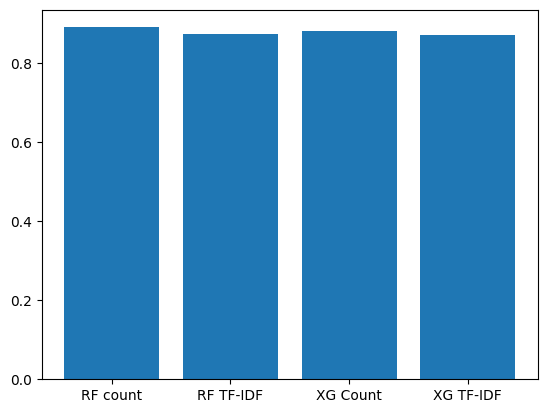

In [ ]:
# XG Boost

# Extereme Gradient Boosting (XG boost) on Count Vectors
accuracy3 = train_model(xgboost.XGBClassifier(), X_train_count.tocsc(), y_train, X_test_count.tocsc(), y_test)
print("Xgb, Count Vectors: ", accuracy3)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accurac4 = train_model(xgboost.XGBClassifier(), X_train_tfidf.tocsc(), y_train, X_test_tfidf.tocsc(), y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy4)

# # Extereme Gradient Boosting on Character Level TF IDF Vectors
# accuracy = train_model(xgboost.XGBClassifier(), X_train_tfidf_ngram_chars.tocsc(), y_train, X_test_tfidf_ngram_chars.tocsc(), y_test)
# print("Xgb, CharLevel Vectors: ", accuracy)
df = {'ModelType': ['RF count', 'RF TF-IDF','XG Count', 'XG TF-IDF' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])